<a href="https://colab.research.google.com/github/Suiii71/Car-Damage-Classification-Repair-Cost-Prediction-A-Machine-Learning-Approach/blob/main/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader,random_split
from torchvision import transforms, models
from torchvision import datasets, transforms
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
base_path = "/content/drive/MyDrive/Car_Damage_Project"

train_csv = base_path + "/CarDD_classification_train.csv"
test_csv  = base_path + "/CarDD_classification_test.csv"

train_img_dir = base_path + "/train2017"
test_img_dir  = base_path + "/test2017"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


part-2

In [ ]:
#Creating Dataset Class
class CarDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform

        # Use the correct column name: "label"
        labels = sorted(self.df['label'].unique())
        self.label_to_idx = {l:i for i,l in enumerate(labels)}
        self.df['label_idx'] = self.df['label'].map(self.label_to_idx)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_path = os.path.join(self.img_dir, row['image'])
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, row['label_idx']


upgrade

In [ ]:
train_csv1 = pd.read_csv(train_csv)
labels = train_csv1["label"]

# Encode labels
le = LabelEncoder()
encoded = le.fit_transform(labels)

# Calculate class weights
class_counts = torch.bincount(torch.tensor(encoded))
class_weights = 1.0 / class_counts.float()
class_weights = class_weights / class_weights.sum()

print("Class weights:", class_weights)

Class weights: tensor([0.2241, 0.0327, 0.0808, 0.4514, 0.0294, 0.1816])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))

In [ ]:
# data=pd.read_csv(train_csv)
# data.head()

In [ ]:
#Transformation(Augmentation and Normalization included)
# from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [ ]:
#rebuilding Dataloaders
train_dataset = CarDataset(train_csv, train_img_dir, train_transform)
test_dataset  = CarDataset(test_csv,  test_img_dir,  test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)


In [ ]:
# Adding class weights to handle imbalance
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_dataset.label_to_idx)

# count how many samples for each class index 0..num_classes-1
label_counts = train_dataset.df['label_idx'].value_counts().sort_index()
print(label_counts)

# inverse frequency → more weight for rare classes
class_weights = 1.0 / label_counts
class_weights = class_weights / class_weights.sum() * num_classes

class_weights_tensor = torch.tensor(class_weights.values,
                                    dtype=torch.float).to(device)
print("Class weights:", class_weights_tensor)

label_idx
0     141
1     967
2     391
3      70
4    1073
5     174
Name: count, dtype: int64
Class weights: tensor([1.3445, 0.1961, 0.4849, 2.7083, 0.1767, 1.0895], device='cuda:0')


In [ ]:
#Loading ResNet50
num_classes1 = len(train_dataset.label_to_idx)

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Replace final layer
model.fc = nn.Linear(model.fc.in_features, num_classes1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
# #Training and optimizing with adam
# criterion1 = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
# #Creating Early stop class
# class EarlyStopping:
#     def __init__(self, patience=5):
#         self.patience = patience
#         self.counter = 0
#         self.best_acc = 0
#         self.early_stop = False

#     def __call__(self, val_acc):
#         if val_acc > self.best_acc:
#             self.best_acc = val_acc
#             self.counter = 0
#         else:
#             self.counter += 1
#             if self.counter >= self.patience:
#                 self.early_stop = True

In [ ]:
# #initializing early stop
# early_stopper = EarlyStopping(patience=5)

In [ ]:
from torchvision import models
import torch.nn as nn

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

epochs = 15

for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    scheduler.step()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")

Epoch [1/15], Loss: 1.2495
Epoch [2/15], Loss: 0.6619
Epoch [3/15], Loss: 0.4389
Epoch [4/15], Loss: 0.3265
Epoch [5/15], Loss: 0.2768
Epoch [6/15], Loss: 0.1848
Epoch [7/15], Loss: 0.1627
Epoch [8/15], Loss: 0.1593
Epoch [9/15], Loss: 0.1484
Epoch [10/15], Loss: 0.1367
Epoch [11/15], Loss: 0.1214
Epoch [12/15], Loss: 0.1222
Epoch [13/15], Loss: 0.1240
Epoch [14/15], Loss: 0.1377
Epoch [15/15], Loss: 0.1244


In [ ]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        out = model(imgs)
        _, preds = torch.max(out, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    return accuracy, correct, total


In [ ]:
#ResNet50
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs)
        _, preds = outputs.max(1)

        total += labels.size(0)
        correct += (preds == labels).sum().item()

accuracy = correct / total
print("Test Accuracy:", accuracy)

Test Accuracy: 0.7887700534759359


Classes: ['crack', 'dent', 'glass shatter', 'lamp broken', 'scratch', 'tire flat']


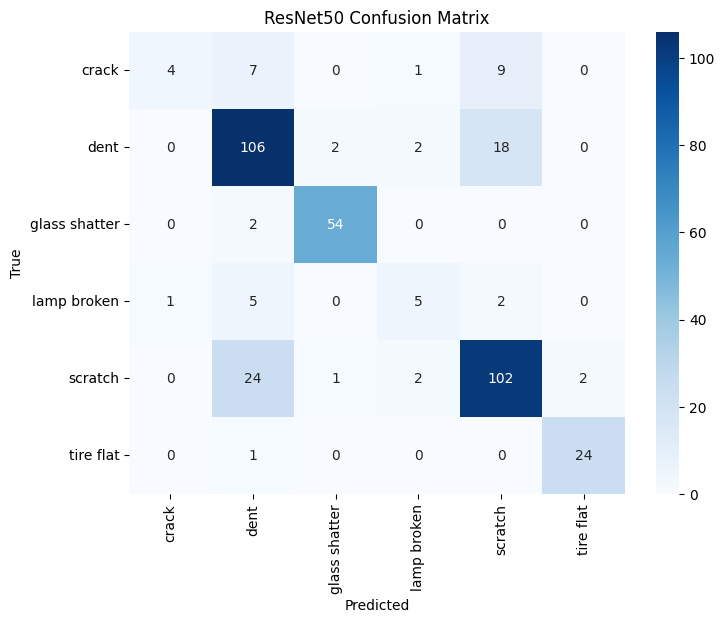


Classification Report:

               precision    recall  f1-score   support

        crack       0.80      0.19      0.31        21
         dent       0.73      0.83      0.78       128
glass shatter       0.95      0.96      0.96        56
  lamp broken       0.50      0.38      0.43        13
      scratch       0.78      0.78      0.78       131
    tire flat       0.92      0.96      0.94        25

     accuracy                           0.79       374
    macro avg       0.78      0.68      0.70       374
 weighted avg       0.79      0.79      0.78       374

Final Test Accuracy = 0.7887700534759359


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
classes = sorted(train_csv1['label'].unique())

print("Classes:", classes)

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6 ))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=classes,
    yticklabels=classes
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("ResNet50 Confusion Matrix")
plt.show()
# Classification Report
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=classes))

# -----------------------------
# Test Accuracy
# -----------------------------
accuracy = (all_preds == all_labels).mean()
print("Final Test Accuracy =", accuracy)